In [2]:
import geopandas as gpd
import pandas as pd
from rasterstats import zonal_stats
import os
import rasterio

from tqdm import tqdm

import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np

In [5]:
os.chdir(r"C:\Users\jarem\OneDrive - London School of Economics\YEAR 2\PP4V8 - policy paper\policy-paper-repo")


In [80]:
raster_folder_path = "data/inputs/2. outcome_vars/GDP_025d (2000-2100)/025d"
vector_path = "data/inputs/shapefiles/polska/gminy/gminy.shp"
output_csv_path = "data/clean/outcome/GDP"

In [ ]:
iso3_gdf = gpd.read_file(vector_path)

In [14]:
iso3_gdf.columns

Index(['gml_id', 'JPT_SJR_KO', 'JPT_POWIER', 'JPT_KOD_JE', 'JPT_NAZWA_',
       'JPT_ORGAN_', 'JPT_JOR_ID', 'WERSJA_OD', 'WERSJA_DO', 'WAZNY_OD',
       'WAZNY_DO', 'JPT_KOD__1', 'JPT_NAZWA1', 'JPT_ORGAN1', 'JPT_WAZNA_',
       'ID_BUFORA_', 'ID_BUFORA1', 'ID_TECHNIC', 'IIP_PRZEST', 'IIP_IDENTY',
       'IIP_WERSJA', 'JPT_KJ_IIP', 'JPT_KJ_I_1', 'JPT_KJ_I_2', 'JPT_OPIS',
       'JPT_SPS_KO', 'ID_BUFOR_1', 'JPT_ID', 'JPT_POWI_1', 'JPT_KJ_I_3',
       'JPT_GEOMET', 'JPT_GEOM_1', 'SHAPE_LENG', 'SHAPE_AREA', 'REGON',
       'RODZAJ', 'geometry'],
      dtype='object')

In [31]:
results_gdf = iso3_gdf[['JPT_POWIER','JPT_KOD_JE', 'JPT_NAZWA_', 'geometry']].copy()

In [38]:
first_raster_path = os.path.join(raster_folder_path, f"GDP{start_year}.tif")
if not os.path.exists(first_raster_path):
    raise FileNotFoundError(f"Could not find the first raster file to check CRS: {first_raster_path}")

# Open the raster to get its CRS
with rasterio.open(first_raster_path) as src:
    raster_crs = src.crs
    print(f"Raster CRS found: {raster_crs}")

Raster CRS found: EPSG:4326


In [39]:
if results_gdf.crs != raster_crs:
    print("CRS mismatch detected! Reprojecting vector data to match raster CRS...")
    results_gdf = results_gdf.to_crs(raster_crs)
    print(f"Vector data reprojected. New CRS: {results_gdf.crs}")
else:
    print("CRS match. No reprojection needed.")

CRS mismatch detected! Reprojecting vector data to match raster CRS...
Vector data reprojected. New CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


In [51]:
start_year = 2000
end_year = 2020

In [52]:
years = range(start_year, end_year + 1)

for year in tqdm(years, desc="Processing annual GDP data"):
    # Construct the path to the raster file for the current year
    raster_filename = f"GDP{year}.tif"
    raster_path = os.path.join(raster_folder_path, raster_filename)

    if not os.path.exists(raster_path):
        print(f"Warning: Raster file not found for year {year}, skipping. Path: {raster_path}")
        # Create a column with null values if the file is missing
        stats = [{'sum': None}] * len(results_gdf)
    else:
        # Calculate the 'sum' statistic for the current year's raster
        stats = zonal_stats(
            results_gdf,
            raster_path,
            stats="sum",
            all_touched=True,
            geojson_out=False
        )

    # Extract just the 'sum' values from the list of dictionaries
    gdp_values = [s['sum'] for s in stats]
    
    # Create a new column in our results GeoDataFrame for the current year
    # e.g., 'GDP_2000', 'GDP_2001', etc.
    column_name = f"GDP_{year}"
    results_gdf[column_name] = gdp_values

print("\nAll years processed.")


Processing annual GDP data: 100%|██████████| 21/21 [06:19<00:00, 18.09s/it]


All years processed.


In [53]:
final_df = pd.DataFrame(results_gdf.drop(columns='geometry'))

for year in years:
    col = f"GDP_{year}"
    if col in final_df.columns:
        final_df[col].fillna(0, inplace=True)

C:\Users\jarem\AppData\Local\Temp\ipykernel_49680\1954314952.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_df[col].fillna(0, inplace=True)


In [54]:
final_df.GDP_2000

0       3.889422e+08
1       5.165168e+07
2       1.287878e+09
3       5.998440e+08
4       3.968971e+08
            ...     
2472    4.989589e+08
2473    8.339446e+08
2474    2.475870e+08
2475    1.606455e+08
2476    4.222238e+08
Name: GDP_2000, Length: 2477, dtype: float64

In [57]:
final_df

,JPT_POWIER,JPT_KOD_JE,JPT_NAZWA_,GDP_2000,GDP_2001,GDP_2002,GDP_2003,GDP_2004,GDP_2005,GDP_2006,...,GDP_2011,GDP_2012,GDP_2013,GDP_2014,GDP_2015,GDP_2016,GDP_2017,GDP_2018,GDP_2019,GDP_2020
0,4889,3215011,Szczecinek,3.889422e+08,2.555712e+08,7.644698e+08,3.467652e+08,2.160117e+08,2.926117e+08,2.769835e+08,...,4.734422e+08,5.418872e+08,5.166892e+08,8.015943e+08,8.602926e+08,8.881837e+08,9.540196e+08,9.472585e+08,7.775851e+08,1.187845e+09
1,15063,0619072,Wola Uhruska,5.165168e+07,4.713441e+07,4.960857e+07,5.563014e+07,8.121717e+07,5.290166e+07,5.472313e+07,...,6.555938e+07,4.731405e+07,6.046301e+07,4.880847e+07,6.222308e+07,5.183884e+07,5.685022e+07,4.992023e+07,4.709965e+07,5.483509e+07
2,19465,2214023,Gniew,1.287878e+09,1.016623e+09,1.386642e+09,1.327758e+09,1.232018e+09,1.805109e+09,1.774072e+09,...,1.373721e+09,2.018204e+09,1.891759e+09,3.117452e+09,2.506532e+09,3.205776e+09,3.035729e+09,3.717438e+09,2.966689e+09,4.091925e+09
3,9068,2214032,Morzeszczyn,5.998440e+08,3.737553e+08,5.668265e+08,6.136954e+08,5.586173e+08,8.693016e+08,9.659535e+08,...,6.392861e+08,8.517907e+08,9.940500e+08,1.326387e+09,1.323020e+09,1.363478e+09,1.538624e+09,1.600748e+09,1.345494e+09,1.540672e+09
4,10903,1406062,Jasieniec,3.968971e+08,3.411380e+08,4.690427e+08,4.235667e+08,6.229276e+08,4.627274e+08,5.983839e+08,...,6.574577e+08,6.596370e+08,7.713661e+08,7.548490e+08,9.932011e+08,8.717209e+08,9.064883e+08,1.004819e+09,1.421450e+09,1.232559e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2472,40158,2815092,Ostróda,4.989589e+08,5.199542e+08,9.390726e+08,6.590252e+08,6.802830e+08,5.780204e+08,6.036274e+08,...,8.700913e+08,1.290541e+09,1.152089e+09,1.909528e+09,1.586238e+09,1.830690e+09,1.368596e+09,1.945662e+09,1.802455e+09,1.842299e+09
2473,8416,2612022,Łubnice,8.339446e+08,1.225099e+09,1.043958e+09,8.931500e+08,1.180004e+09,1.491930e+09,1.735345e+09,...,1.892697e+09,3.075081e+09,2.870734e+09,2.210227e+09,1.911281e+09,2.303739e+09,2.722469e+09,2.484328e+09,2.895596e+09,2.985689e+09
2474,14129,1407062,Magnuszew,2.475870e+08,2.169601e+08,2.909372e+08,2.650876e+08,3.914825e+08,2.782337e+08,2.861343e+08,...,3.704037e+08,3.344447e+08,3.879543e+08,3.433165e+08,3.996328e+08,3.787382e+08,4.353007e+08,4.636564e+08,7.364966e+08,6.645830e+08
2475,11438,3207043,Międzyzdroje,1.606455e+08,9.888762e+07,1.134565e+08,1.485350e+08,1.299077e+08,1.987891e+08,2.314924e+08,...,2.217180e+08,1.409172e+08,3.100966e+08,4.468439e+08,5.582257e+08,5.256348e+08,4.942857e+08,4.770651e+08,6.373477e+08,6.708598e+08


In [61]:
final_df.JPT_NAZWA_.nunique()

2236

In [83]:
final_df.to_csv(f"{output_csv_path}/GDP_gmina.csv", index=False)

Data range for color scale: Min=21,076,858.00, Max=153,710,133,248.00


C:\Users\jarem\AppData\Local\Temp\ipykernel_49680\852551774.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


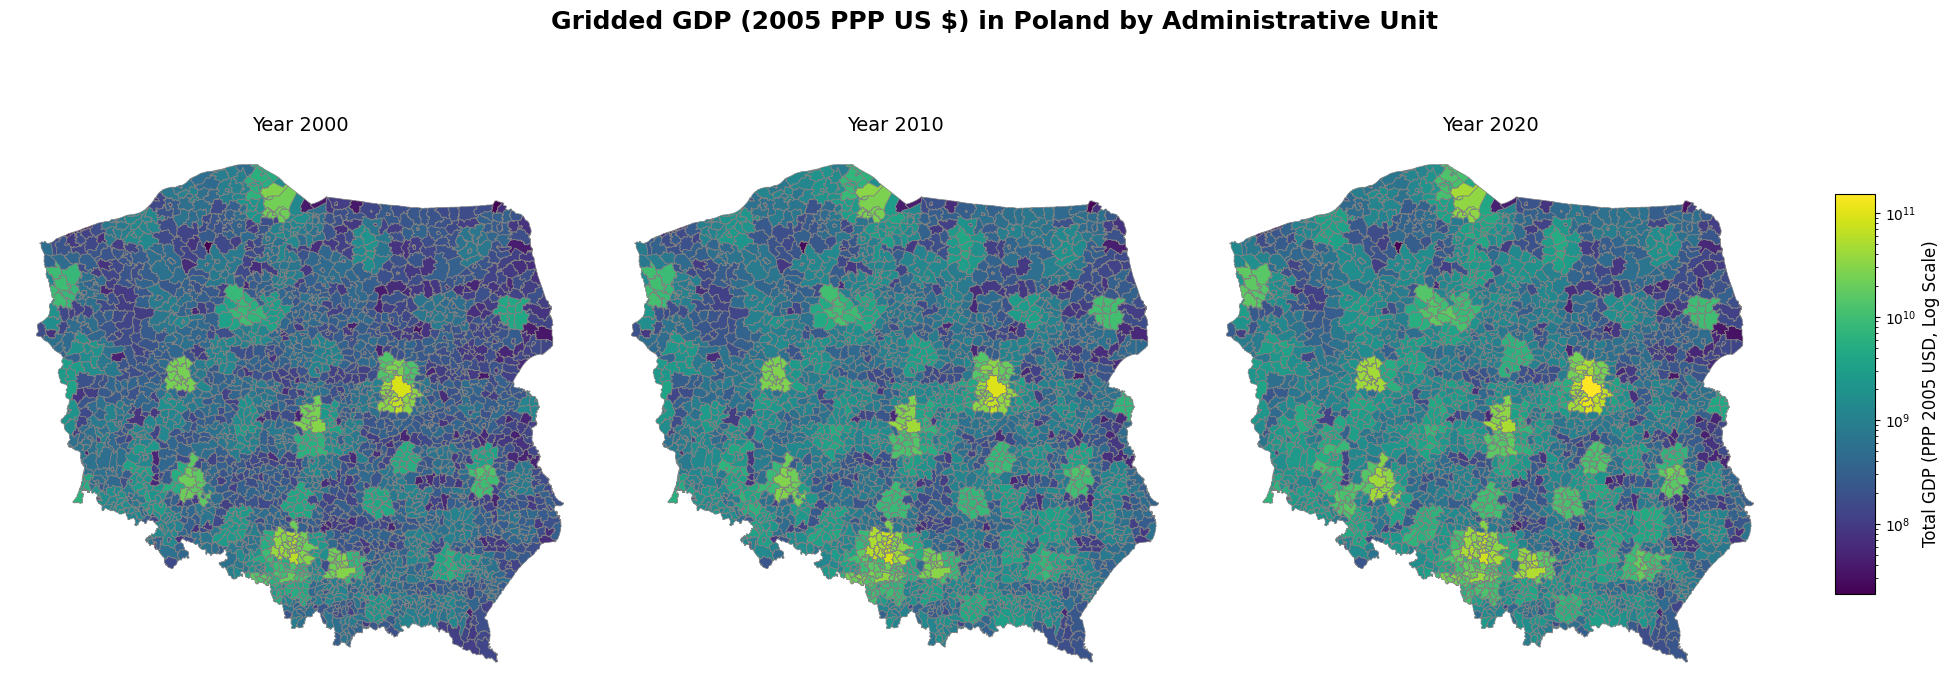

In [74]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np

# --- Prerequisites ---
# Ensure you have the 'results_gdf' GeoDataFrame from the previous analysis.
# It should contain the 'geometry' column and columns like 'GDP_PPP_1990', etc.

# If you are starting a new script, you would first need to load your data.
# For example, if you saved it as a GeoPackage:
# results_gdf = gpd.read_file("gdp_ppp_timeseries_by_unit.gpkg")

# --- 1. Prepare for Plotting ---

# Define the years available in the dataset.
YEARS_AVAILABLE = [2000, 2010, 2020]
# Directly define the column names we will be plotting.
gdp_columns = [f"GDP_{year}" for year in YEARS_AVAILABLE]

# To ensure a consistent color scale, find the min and max GDP across ALL years.
# We add a small value to prevent issues with log(0) for units with no GDP.
min_gdp = results_gdf[gdp_columns].replace(0, np.nan).min().min()
max_gdp = results_gdf[gdp_columns].max().max()

print(f"Data range for color scale: Min={min_gdp:,.2f}, Max={max_gdp:,.2f}")

# --- 2. Create the Subplots ---

# Set up a figure with 1 row and 3 columns of subplots.
fig, axes = plt.subplots(1, len(YEARS_AVAILABLE), figsize=(20, 8), sharex=True, sharey=True)

# Set a main title for the entire figure.
fig.suptitle('Gridded GDP (2005 PPP US $) in Poland by Administrative Unit', fontsize=18, fontweight='bold')

# --- 3. Loop and Plot Each Year ---

for i, year in enumerate(YEARS_AVAILABLE):
    ax = axes[i]
    # Directly use the constructed column name.
    column_to_plot = gdp_columns[i]

    # Plot the data for the current year on its specific subplot (ax).
    results_gdf.plot(
        column=column_to_plot,
        ax=ax,
        cmap='viridis',
        linewidth=0.5,
        edgecolor='0.5',
        # Use LogNorm for the logarithmic color scale.
        norm=LogNorm(vmin=min_gdp, vmax=max_gdp),
        legend=False, # We will create a single, shared colorbar.
        missing_kwds={
            "color": "lightgrey",
            "label": "No Data",
        },
    )

    # --- 4. Customize Each Subplot ---
    ax.set_title(f"Year {year}", fontsize=14)
    ax.set_axis_off() # Turn off the lat/lon axes for a cleaner look.

# --- 5. Add a Single, Shared Colorbar ---

# Create a new axis for the colorbar to control its position and size.
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])

# Create the colorbar itself.
sm = plt.cm.ScalarMappable(cmap='viridis', norm=LogNorm(vmin=min_gdp, vmax=max_gdp))
sm._A = [] # Empty array for the scalar mappable.
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Total GDP (PPP 2005 USD, Log Scale)', fontsize=12)

# Adjust layout to prevent titles from overlapping and make space for the colorbar.
plt.tight_layout(rect=[0, 0, 0.9, 1])

# Display the plot.
plt.show()
